# Q-learning with Function Approximation

In this notebook, we will create a Q-learning agent that approximatse a state-action value for each state-action pair using a function instead of using a dictionary to store all state-action values. We use the `CartPole-v1` environment (solved at average score of 195 over the last 100 episodes) to test our agent.

In [1]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
from tqdm import tqdm_notebook

import gym

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

/home/hangtenz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hangtenz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hangtenz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hangtenz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
#animation snippets
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from pyvirtualdisplay import Display
#display
# enable eager exection
tf.enable_eager_execution()

display = Display(visible=0, size=(512, 512))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

## [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/)

The pole balancing task is described as fololows:

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [3]:
env = gym.make('CartPole-v1')

**Assignment** Find out what are the following elements

* States:
* Actions:
* Rewards: 

In [4]:
# Use this cell to try execute the following functions:
# * env.reset() - reset the environment and return the current state
# * env.step(action) - take an action at the current state; returns a tuple of (state, reward, done, info)
print(env.reset())
#step is 0 or 1
env.step(1)
# state is array dimension = 4

[-0.03479629 -0.04028404  0.03023225  0.0371896 ]


(array([-0.03560197,  0.15439162,  0.03097604, -0.24580353]), 1.0, False, {})

## Random Play

Here is how you do one episode of the environment. We also provide the code for saving the frames for rendering, which could be useful for debugging. Once you have a good model, you can see it play by using the following rendering codes.

In [5]:
env = gym.make('CartPole-v1')
state = env.reset()
score = 0
t=0
frames = [] #to store frames for rendering

while True:
    action = np.random.choice(range(env.action_space.n))
    state, reward, done, info = env.step(action)
    t+=1
    score+=reward
    
    #rendering
    frames.append(env.render(mode = 'rgb_array'))
    if done: break
# frames array refer array of (r,g,b) of picture in each frame
#print(frames)
print('Done in '+ str(t) +' timsteps with score ' + str(score) + '.')

Done in 10 timsteps with score 10.0.


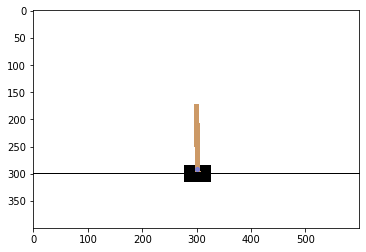

In [6]:
#animate frames
patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 100)
HTML(ani.to_jshtml())

## Training Loop

For the training loop, we train the agent for a given number of episodes, for instance, until the average score of the last 100 episodes is above the solved score of 200. `deque` is a collection object that stores the last `x` elements and is convenient to use for keep score.

In [7]:
from datetime import datetime
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score= 200

for i in tqdm_notebook(range(1000)):
    if (i+1) % 100==0: print('Episdoe '+str(i) + ' Moving Average: '+str(np.mean(scores_deque)))
    state = env.reset() #get initial state
    score = 0
    while True:
        #select random action
        action = np.random.choice(range(env.action_space.n))

        #env step
        next_state, reward, done, info = env.step(action)
        
        #agent step
        #we don't have an agent now
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
        
    if moving_scores[-1] > solved_score: 
        print('Solved at Play '+str(i)+': '+str(datetime.now() - start_time)+' Moving average: '+str(moving_scores[-1]))
        break

Episdoe 99 Moving Average: 22.626262626262626
Episdoe 199 Moving Average: 21.84
Episdoe 299 Moving Average: 22.14
Episdoe 399 Moving Average: 21.42
Episdoe 499 Moving Average: 22.68
Episdoe 599 Moving Average: 22.75
Episdoe 699 Moving Average: 25.09
Episdoe 799 Moving Average: 23.04
Episdoe 899 Moving Average: 19.29
Episdoe 999 Moving Average: 22.57



## Your First Q-Network

Instead of using a dictionary with all state-action pairs, we use a model that takes any state-action pair as an input and output the Q-value.

In [8]:
'''
Fill in the codes for your Q-network
'''
class DenseNetwork(models.Model):
    def __init__(self, output_size, hidden_sizes):
        super(DenseNetwork, self).__init__()
        self.linears = [layers.Dense(i,activation='relu') for i in hidden_sizes]
        self.linears.append(layers.Dense(output_size, activation=None))
    def call(self, x):
        for l in self.linears[:-1]:
            x = l(x)
        return self.linears[-1](x)

In [9]:
state = env.reset()
print(state)
print(state[None,:] , "type = ",type(state[None,:]))

[-0.04697198  0.04819332  0.00079485 -0.00241944]
[[-0.04697198  0.04819332  0.00079485 -0.00241944]] type =  <class 'numpy.ndarray'>


In [10]:
#from solutions.networks import DenseNetwork
m = DenseNetwork(env.action_space.n, [128,64])
m(env.reset()[None,:])

<tf.Tensor: id=81, shape=(1, 2), dtype=float64, numpy=array([[ 0.00363981, -0.00172678]])>

## Fill in The Agent

Fill in the missing parts of the agent and try to solve `CartPole-v1` as quickly as possible: least number of timesteps and/or shortest time in seconds. The person who can solve the environment the quickest will receive a special prize.

Some ways to optimize the agent:
* Choose a suitable Q-value approximator
* Think about how you update the approximator; how many times? batch size?
* Be creative with your explore-vs-exploit scheme for choosing an action
* Make sure the agent gets the right rewards

In [11]:
#with input shape
m = tf.keras.Sequential()
m.add(tf.keras.layers.Dense(32,activation='relu',input_dim=4))
m.add(tf.keras.layers.Dense(32,activation='relu'))
m.add(tf.keras.layers.Dense(1))
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [12]:
class QAgent:
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.losses = [] #to store losses for visualization
        self.t_step = 0 # count time steps

        '''
        Fill in your codes to create network, optimizer and loss function here
        '''
        self.network_local = DenseNetwork(env.action_space.n, [128,64])
        self.optimizer = optimizers.Adam()
        self.loss_fn = tf.keras.losses.MeanSquaredError()


    def step(self, states, actions, rewards, next_states, dones):
        self.t_step += 1
        loss = self.learn(states.reshape(1,-1), 
                          np.array(actions).reshape(1,-1), 
                          np.array(rewards).reshape(1,-1), 
                          next_states.reshape(1,-1), 
                          np.array(dones).reshape(1,-1))
        self.losses.append(loss)
            
    def get_eps(self, i, eps_start=1., eps_end=0.001, eps_decay=0.9999):
        '''
        Fill in your codes to calculate epsilon here
        '''
        eps = eps_start * pow(eps_decay, i)
        return eps if eps >= eps_end else eps_end
                    
    def act(self, state):
        '''
        Fill in codes to perform epsilon greedy action
        '''
        if random.random() < self.get_eps(self.t_step):
            return np.random.randint(self.action_size)
        return np.argmax(self.network_local(state[None])[0])

    def learn(self, states, actions, rewards, next_states, dones, gamma=0.99):
        '''
        Fill in the codes to update the network
        '''
        #get q-values for next states
        q_targets_next = np.amax(self.network_local(next_states), axis=1)
        
        #bellman's equation
        q_targets = rewards + (1 - dones) * gamma * q_targets_next
        q_targets = q_targets[:,0] #flatten q_targets

        with tf.GradientTape() as tape:
            #get q-values of all actions
            preds = self.network_local(states)
            
            #get index of actions used to calculate q_expected
            actions = actions[:,0] #flatten actions
            action_idxs = [[i, a] for i, a in enumerate(actions)]

            #get q values only at specific action indice
            #tensorflow has this weird way to gather where you need to put index as
            #[[0, action_idx1],[1, action_idx2],...,[n, action_idxn]]
            #Hint: method is tf.gather_nd
            q_expected = tf.gather_nd(preds, action_idxs)
            
            #calculate loss
            loss = self.loss_fn(q_targets, q_expected)
            
            #get gradients
            gradients = tape.gradient(loss, self.network_local.trainable_weights)
        
        #apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.network_local.trainable_weights))
        return loss

In [13]:
m = DenseNetwork(2,[128,64])
state = np.array([1.0,2.0,3.0,4.0])
state = np.reshape(state,(-1,4))

optimizer = tf.train.GradientDescentOptimizer(0.1)

loss_fn = tf.keras.losses.MeanSquaredError()



state2 = np.array([5.0,6.0,7.0,8.0])
state2 = np.reshape(state2,(-1,4))
    
with tf.GradientTape() as tape:
    y = tf.convert_to_tensor([[2.0,3.5]] , np.float64)
    print("y = ",y)
    pred = m(state)
    print("pred = ",pred)
    train_loss = loss_fn(y,pred)
    #print("train_loss=",tf.keras.backend.eval(train_loss))
    print("train_loss = ",train_loss)
    gradients = tape.gradient(train_loss,m.trainable_weights)
#print(gradients)
optimizer.apply_gradients(zip(gradients,m.trainable_weights))


y =  tf.Tensor([[2.  3.5]], shape=(1, 2), dtype=float64)
pred =  tf.Tensor([[0.00348085 0.17130605]], shape=(1, 2), dtype=float64)
train_loss =  tf.Tensor(7.533145904541016, shape=(), dtype=float64)


In [14]:
#from solutions.agents import QAgent

env = gym.make('CartPole-v1')
a = QAgent(state_size = env.reset().shape[0], action_size = env.action_space.n) 

In [17]:
from datetime import datetime

scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score= 200

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episode {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    while True:
        t+=1
        #select action
        action = a.act(state)  

        #env step
        next_state, reward, done, info = env.step(action)   
    
        #agent step
        a.step(state,action,reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
        
    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

Episode 99 Moving Average: 23.19191919191919
Episode 199 Moving Average: 33.7
Episode 299 Moving Average: 68.12
Episode 399 Moving Average: 170.68
Solved at Play 439: 0:06:23.664816 Moving average: 201.25


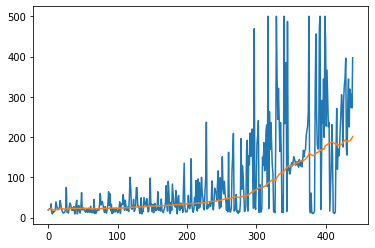

In [18]:
#plot the score and moving scores
plt.plot(scores)
plt.plot(moving_scores)

## Render The Smart Agent

Use the render codes above to render your smart agent.

Done in 377 timsteps with score 377.0.


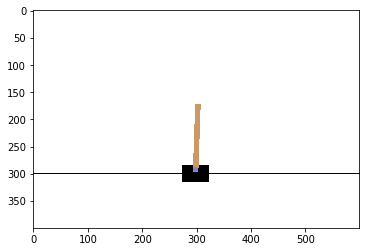

In [19]:
env = gym.make('CartPole-v1')
state = env.reset()
score = 0
t=0
frames = [] #to store frames for rendering

while True:
    action = a.act(state)
    
    state, reward, done, info = env.step(action)
    t+=1
    score+=reward
    
    #rendering
    frames.append(env.render(mode = 'rgb_array'))
    if done: break
print(f'Done in {t} timsteps with score {score}.')

patch = plt.imshow(frames[0])
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 100)
HTML(ani.to_jshtml())

## Bonus Question: Plot The Losses

In supervised learning, we often look at the batch-wise losses of a model to see if the model is "learning well". In our case, what does a loss plot of an agent that is "learning well" looks like and why?

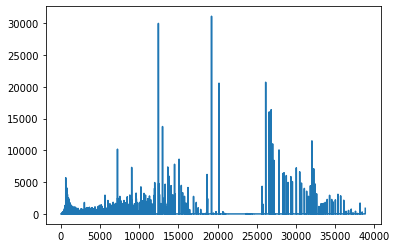

In [20]:
plt.plot(a.losses)